# Extending previous Machine-learning paper

The first attempt at the Met Office to apply Machine Learning techniques to the problem of missing metadata in the XBT dataset was done by Thomas P. Leahy and Francesc Llopis working with Niall Robinson and Matt Palmer. 

https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0012.1?af=R&mobileUi=0

They trained neural network classifier on the XBT data, using the same features, country, date of profile and maximum depth, as the iMeta algorithm. They did not train on the whole dataset, but rather year by year.
In this notebook we are building on the results, which have been replicated in another notebook. Here we will consider some small changes, such as training on larger subsets or the whole dataset, using additional features and doing hyper parameter tuning.

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [6]:
from xbt_dataset import XbtDataset

In [7]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [8]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [9]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']
train_fraction = 0.75
test_fraction = 1 - train_fraction

## Preparing the data

In [10]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

load the following features: ['country', 'institute', 'platform', 'cruise_number', 'instrument', 'imeta_applied', 'max_depth', 'lat', 'lon', 'id', 'date']


In [11]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


## Calculating iMeta results

For comparison, we calculate the output from the intelligent metadata algorithm to compare results with ML artificial neaural network results.


In [12]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)


In [13]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})').astype('category', catergories=xbt_labelled['instrument'].cat.categories)
imeta_model = imeta_classes.apply(lambda t1: t1[0]).astype('category', catergories=xbt_labelled['model'].cat.categories)
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1]).astype('category', catergories=xbt_labelled['manufacturer'].cat.categories)

## Training and evaluating neural networks for each year

To replicate the paper results, we use the scikit-learn MLPClassifier class, training one classifier for year in the XBT dataset.  For each of those years, we split the profiles into training and test sets, train the classifier, then calculate the classification metrics on the train and test sets. The main metric used in the paper was recall.
The results are then collated in a dataframe, together with the classification metrics for the iMeta classification output.

First add a train/test split field to the labelled data frame. Thi is so we can easily either train and evaluate on different periods, e.g. train on whole dataset and look at performance per year

In [14]:
xbt_train_all, xbt_test_all = xbt_labelled.train_test_split(split_on_feature='year')

Create the feature encoders on the whole dataset so comparisons are possible. This will create encoders based on the whole datasert. When we subset the data using filter_obs or filter_features, the encoders will be passed to the subset and used there. This way we know whatever subset we process, the encodings will be the same so the results can be easily compared.

In [15]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [16]:
def classify_subset(classifier_class, xbt_subset, x_features, y_feature):
    xbt_train_year, xbt_test_year = xbt_subset.train_test_split()
    (X_train, _, _, _) = xbt_train_year.filter_features(x_features).get_ml_dataset()
    (X_test, _, _, _) = xbt_test_year.filter_features(x_features).get_ml_dataset()
    (y_train, _, _, _) = xbt_train_year.filter_features([y_feature]).get_ml_dataset()
    (y_test, _, _, _) = xbt_test_year.filter_features([y_feature]).get_ml_dataset()
    clf_mlp1 = classifier_class()
    clf_mlp1.fit(X_train, y_train)
    y_res_train = clf_mlp1.predict(X_train)
    metric_train = sklearn.metrics.precision_recall_fscore_support(y_train, y_res_train)
    y_res_test = clf_mlp1.predict(X_test)
    metric_test = sklearn.metrics.precision_recall_fscore_support(y_test, y_res_test)
    return {'classifier':clf_mlp1,'metrics_train': metric_train, 'metrics_test': metric_test}

In [17]:
classify_nnet = functools.partial(classify_subset, sklearn.neural_network.MLPClassifier)

In [19]:
results_instr_all1 = classify_nnet(xbt_labelled, input_feature_names, 'instrument')

In [20]:
results_model_all1 = classify_nnet(xbt_labelled, input_feature_names, 'model')

In [21]:
results_manuf_all1 = classify_nnet(xbt_labelled, input_feature_names, 'manufacturer')

In [22]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [32]:
eval_progress.value = env_date_ranges[environment][0]
metrics_whole_per_year = {}
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    X_train_year = xbt_train_all.filter_obs('year', year).filter_features(input_feature_names).get_ml_dataset()[0]
    X_test_year = xbt_test_all.filter_obs('year', year).filter_features(input_feature_names).get_ml_dataset()[0]
    
    y_res_instr_train_whole_year = results_instr_all1['classifier'].predict(X_train_year)
    y_res_instr_test_whole_year =  results_instr_all1['classifier'].predict(X_test_year)
    y_instr_train_year = xbt_train_all.filter_obs('year', year).filter_features(['instrument']).get_ml_dataset()[0]
    y_instr_test_year = xbt_test_all.filter_obs('year', year).filter_features(['instrument']).get_ml_dataset()[0]

    y_res_model_train_whole_year = results_model_all1['classifier'].predict(X_train_year)
    y_res_model_test_whole_year = results_model_all1['classifier'].predict(X_test_year)
    y_model_train_year = xbt_train_all.filter_obs('year', year).filter_features(['model']).get_ml_dataset()[0]
    y_model_test_year = xbt_test_all.filter_obs('year', year).filter_features(['model']).get_ml_dataset()[0]
    
    y_res_manuf_train_whole_year = results_manuf_all1['classifier'].predict(X_train_year)
    y_res_manuf_test_whole_year = results_manuf_all1['classifier'].predict(X_test_year)
    y_manuf_train_year = xbt_train_all.filter_obs('year', year).filter_features(['manufacturer']).get_ml_dataset()[0]
    y_manuf_test_year = xbt_test_all.filter_obs('year', year).filter_features(['manufacturer']).get_ml_dataset()[0]
    
    metrics_whole_per_year[year] = {
        'metric_instr_year_train': sklearn.metrics.precision_recall_fscore_support(y_instr_train_year, y_res_instr_train_whole_year, average='micro'),
        'metric_instr_year_test' : sklearn.metrics.precision_recall_fscore_support(y_instr_test_year, y_res_instr_test_whole_year, average='micro'),
        'metric_model_year_train': sklearn.metrics.precision_recall_fscore_support(y_model_train_year, y_res_model_train_whole_year, average='micro'),
        'metric_model_year_test' : sklearn.metrics.precision_recall_fscore_support(y_model_test_year, y_res_model_test_whole_year, average='micro'),
        'metric_manuf_year_train': sklearn.metrics.precision_recall_fscore_support(y_manuf_train_year, y_res_manuf_train_whole_year, average='micro'),
        'metric_manuf_year_test' : sklearn.metrics.precision_recall_fscore_support(y_manuf_test_year, y_res_manuf_test_whole_year, average='micro'),
    }
    eval_progress.value = year


## Classification Performance

The results for classification of model and manufacturer separately is shown below. We see that recall is better for manufacturer than model, which is not surprising as it is principally a 2 class problem, with almost all profles being from probes manufactured by Sippican or TSK.

The current iMeta performance does not match that shown in the paper and needs further investigation.

In [78]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    xbt_subset_to_score = xbt_df.filter_obs('year', year, )
    if xbt_subset_to_score.shape[0] == 0:
        return [0.0, 0.0, 0.0, 0]
    X_year = xbt_subset_to_score.filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_subset_to_score.filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [35]:
results_by_year = {}

In [38]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_model' : score_year(xbt_train_all, year,  results_model_all1['classifier'], input_feature_names, 'model'),
        'metric_test_model' : score_year(xbt_test_all, year,  results_model_all1['classifier'], input_feature_names, 'model'),
        'metric_train_manuf' : score_year(xbt_train_all, year,  results_manuf_all1['classifier'], input_feature_names, 'manufacturer'),
        'metric_test_manuf' : score_year(xbt_test_all, year,  results_manuf_all1['classifier'], input_feature_names, 'manufacturer'),
        'metric_train_instr' : score_year(xbt_train_all, year,  results_instr_all1['classifier'], input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year,  results_instr_all1['classifier'], input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [47]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_model' : [m1['metric_train_model'][1] for y1,m1 in results_by_year.items()],
    'recall_test_model' : [m1['metric_test_model'][1] for y1,m1 in results_by_year.items()],
    'recall_train_manuf' : [m1['metric_train_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_test_manuf' : [m1['metric_test_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
})

In [48]:
model_encoder = xbt_labelled._feature_encoders['model']
manuf_encoder = xbt_labelled._feature_encoders['manufacturer']
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [49]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [50]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_model = model_encoder.transform(pandas.DataFrame(imeta_model[xbt_labelled.xbt_df.year == year]))
    xbt_model1 = model_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].model))

    y_imeta_manuf = manuf_encoder.transform(pandas.DataFrame(imeta_manufacturer[xbt_labelled.xbt_df.year == year]))
    xbt_manufacturer1 = manuf_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].manufacturer))

    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    
    
    (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, y_imeta_model,average='micro')
    (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, y_imeta_manuf,average='micro')
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [51]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [59]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

## Paper plots

### Figure 1
* plot 1 - Recall for NN and iMeta per year
* plot 2 - percentage imporvement in recall per year 

In [60]:
results_df.columns

Index(['year', 'recall_train_model', 'recall_test_model', 'recall_train_manuf',
       'recall_test_manuf', 'recall_train_instr', 'recall_test_instr',
       'imeta_model_recall', 'imeta_model_precision', 'imeta_manuf_recall',
       'imeta_manuf_precision', 'imeta_instr_recall', 'imeta_instr_precision',
       'num_samples'],
      dtype='object')

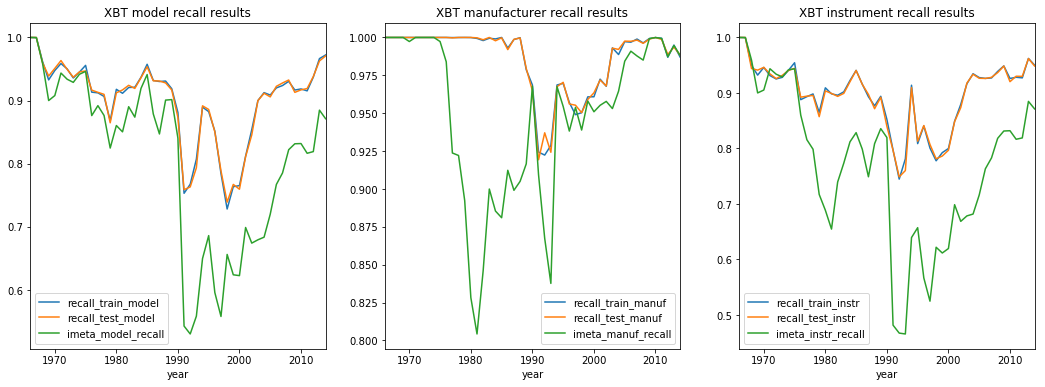

In [55]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(18,6))
ax_model_recall_results = fig_model_recall_results.add_subplot(131, title='XBT model recall results')
_ = results_df.plot.line(x='year',y=['recall_train_model','recall_test_model', 'imeta_model_recall'], ax=ax_model_recall_results)
ax_manuf_recall_results = fig_model_recall_results.add_subplot(132, title='XBT manufacturer recall results')
_ = results_df.plot.line(x='year',y=['recall_train_manuf','recall_test_manuf', 'imeta_manuf_recall'], ax=ax_manuf_recall_results)
ax_instr_recall_results = fig_model_recall_results.add_subplot(133, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

### Anyalysis 
We can see that the results are similar to results in the paper, depsite training on the whole dataset.

Given that there more models than manufacturers, it is not surprising to see that the acuracy for instrument is similar to for model.

In [62]:
results_df['improvement_model'] = results_df.apply(lambda r1: ((r1['recall_test_model'] /  r1['imeta_model_recall'])-1)*100.0 , axis=1)
results_df['improvement_manuf'] = results_df.apply(lambda r1: ((r1['recall_test_manuf'] /  r1['imeta_manuf_recall'])-1)*100.0 , axis=1)
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

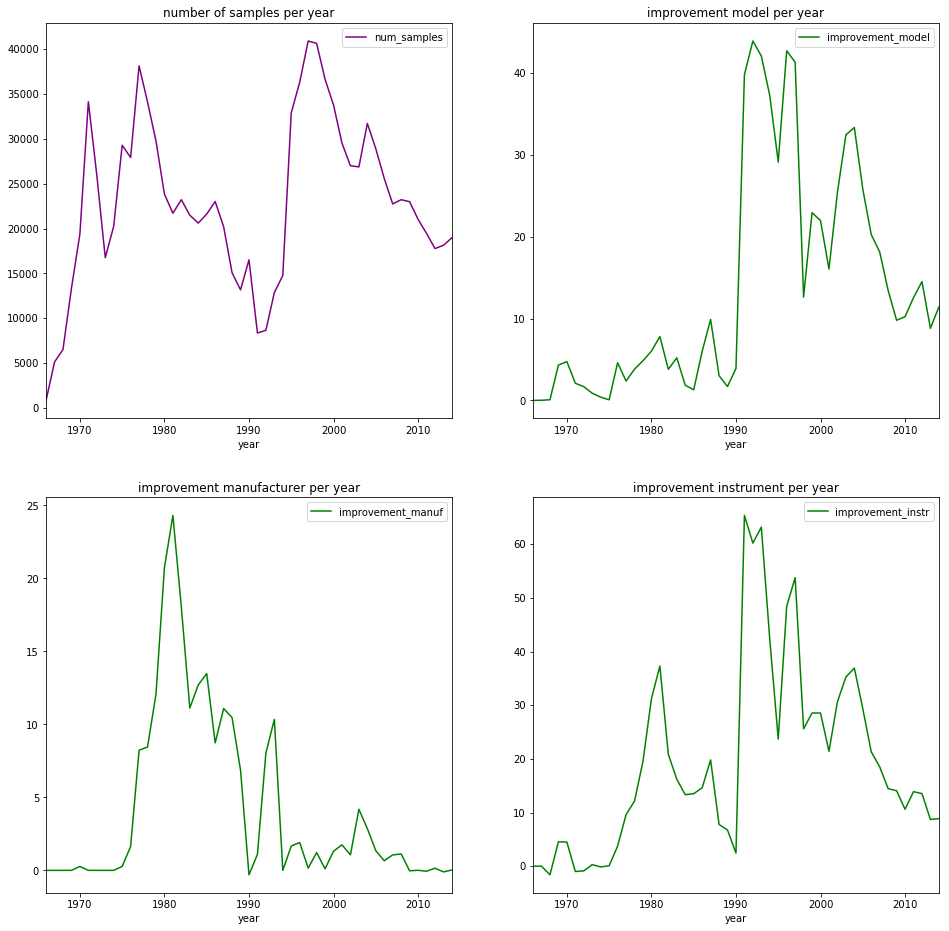

In [64]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,16))
ax_num_samples = fig_num_samples_per_year.add_subplot(221, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(222, title='improvement model per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_model'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(223, title='improvement manufacturer per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_manuf'], c='green' )
ax_num_samples = fig_num_samples_per_year.add_subplot(224, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_instr'], c='green' )



### Figure 2
* plot 1 - recall for the NN for different probe types per year
* plot 2 - number of profiles for each type per year

In [118]:
probe_colors = {'XBT: T4 (SIPPICAN)': 'k', 'XBT: T5 (SIPPICAN)': 'r', 'XBT: T7 (SIPPICAN)': 'g'}
probes_of_interest = list(probe_colors.keys())

In [114]:
recall_by_probe_type = {}
for instr_type in probes_of_interest:
    xbt_instr_subset_train = xbt_train_all.filter_obs('instrument',instr_type)
    xbt_instr_subset_test = xbt_test_all.filter_obs('instrument',instr_type)
    per_probe = []
    for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
        per_probe +=  [{
            'year': year,
            'num_samples' : sum(xbt_labelled.filter_obs('instrument',instr_type).xbt_df.year == year),
            'recall_train' : score_year(xbt_instr_subset_train, year, results_instr_all1['classifier'], input_feature_names, 'instrument')[1],
            'recall_test' : score_year(xbt_instr_subset_test, year, results_instr_all1['classifier'], input_feature_names, 'instrument')[1],
        }]
    recall_by_probe_type[instr_type] = pandas.DataFrame.from_records(per_probe)
    

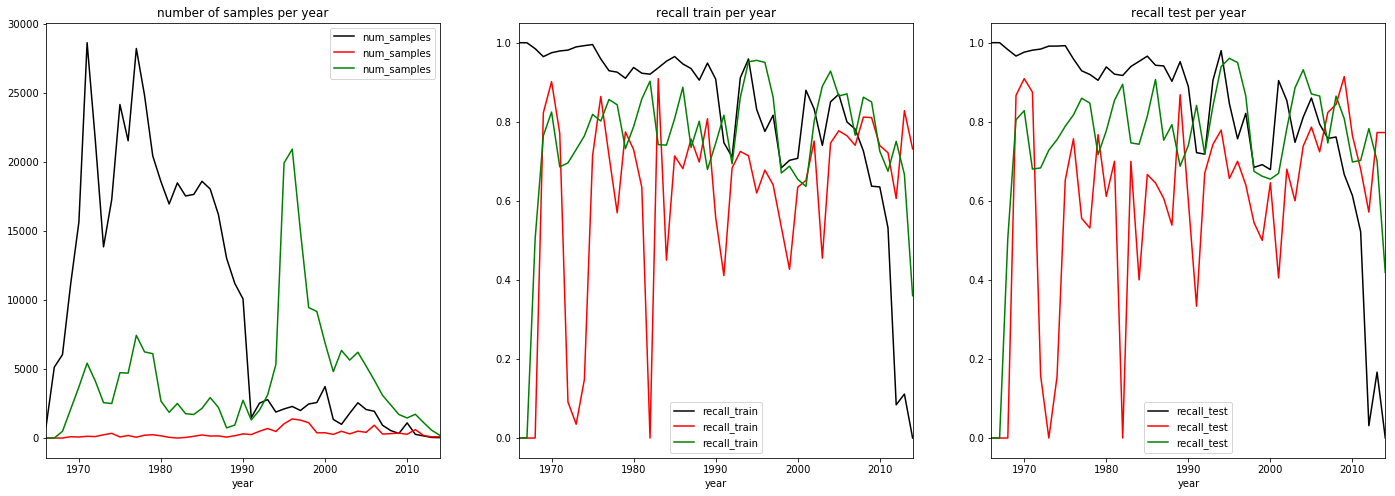

In [122]:
fig_results_per_probe = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(24,8))
ax_num_samples_per_probe = fig_results_per_probe.add_subplot(131, title='number of samples per year')
ax_recall_train_per_probe = fig_results_per_probe.add_subplot(132, title='recall train per year')
ax_recall_test_per_probe = fig_results_per_probe.add_subplot(133, title='recall test per year')
for instr_type in probes_of_interest:
    _ = recall_by_probe_type[instr_type].plot.line(ax=ax_num_samples_per_probe, x='year',y=['num_samples'],c=probe_colors[instr_type] )
    _ = recall_by_probe_type[instr_type].plot.line(ax=ax_recall_train_per_probe, x='year',y=['recall_train'], c=probe_colors[instr_type] )
    _ = recall_by_probe_type[instr_type].plot.line(ax=ax_recall_test_per_probe, x='year',y=['recall_test'], c=probe_colors[instr_type] )



## Further work

The next in improving the results include:
* performing cross-validation 
* trying additional / alternative featues
* hyperparameter tuning on the classifier to evaulate the effect on performance. The paper suggests this did not have much affect on classification performance and thisshould be checked.
